In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

import glob
import time
import yaml
from yaml.loader import SafeLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

import cv2
from imagen_pytorch import Unet, NullUnet, Imagen, SRUnet256, alpha_cosine_log_snr
# from imagen_pytorch import load_imagen_from_checkpoint, ImagenTrainer

from trainer import ImagenTrainer
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image 
import PIL 
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def pred(images, imagen, iter):
    lowres_images = images.cuda()  # starting un-resoluted images [1, 3, 64, 64]

    pred = imagen.sample(
        start_at_unet_number = 2,              # start at unet number 2
        start_image_or_video = lowres_images,  # pass in low resolution images to be resoluted
        cond_scale = 1)

    pred.shape # (1, 3, 256, 256)
    # define a transform to convert a tensor to PIL image
    transform = T.ToPILImage()

    # convert the tensor to PIL image using above transform
    img = transform(pred[0])
    img.save(save_path.split('.')[0]+'_iter_{}.png'.format(iter))
    
def evaluate(imagen):
    # do the above for many many many many steps
    # now you can sample an image based on the text embeddings as well as low resolution images

    lowres_images = torch.randn(3, 3, 64, 64).cuda()  # starting un-resoluted images

    images = imagen.sample(
        texts = [
            'a whale breaching from afar',
            'young girl blowing out candles on her birthday cake',
            'fireworks with blue and green sparkles'
        ],
        start_at_unet_number = 2,              # start at unet number 2
        start_image_or_video = lowres_images,  # pass in low resolution images to be resoluted
        cond_scale = 3.)

    images.shape # (3, 3, 256, 256)
    
def np2tensor(x, length, mode='2d'):
    x = torch.tensor(x)
    if mode == '2d':
        if length == 2:
            x = torch.unsqueeze(x,0)
        elif length == 3:
            x = torch.unsqueeze(x,0)
    else:
        if length == 3:
            x = torch.unsqueeze(x,0)
        elif length == 4:
            x = torch.unsqueeze(x,0)
    return x
            

In [8]:
class Dataset(Dataset):
    def __init__(
        self,
        hr_files,
        lr_files
    ):
        self.hrfiles = hr_files
        self.lrfiles = lr_files
        
        assert len(self.hrfiles) == len(self.hrfiles), "Length should be same"
    
    def transform(self, img, size=(256,256)):
        return TF.resize(img, size)
        
    def normalize(self, img):
        img = (img-img.min())/(img.max()-img.min())
        return img

    def __len__(self):
        return len(self.hrfiles)

    def __getitem__(self, idx):
        hrfile = self.hrfiles[idx]
        lrfile = self.hrfiles[idx].replace('groundtruth_', 'lr_')
        
        hrimg = np.load(hrfile).astype(np.float32)
        hrimg = np2tensor(hrimg, len(hrimg.shape))
        hrimg = self.transform(hrimg)
        hrimg = self.normalize(hrimg)
        
        lrimg = np.load(lrfile).astype(np.float32)
        lrimg = np2tensor(lrimg, len(lrimg.shape))
#         lrimg = self.transform(lrimg,size=(64,64))
        lrimg = self.transform(lrimg)
        lrimg = self.normalize(lrimg)
        
        return hrimg, lrimg

146 146
0


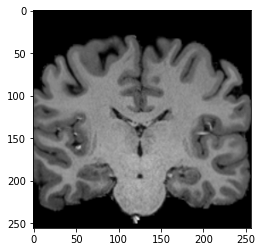

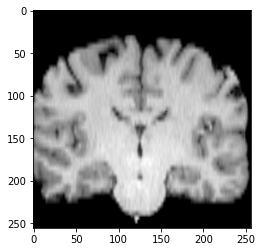

1


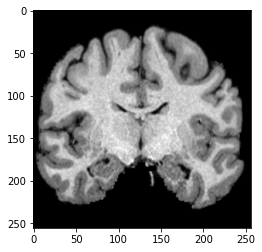

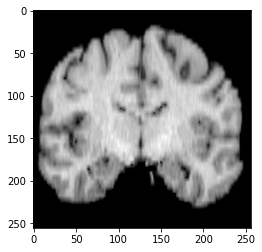

2


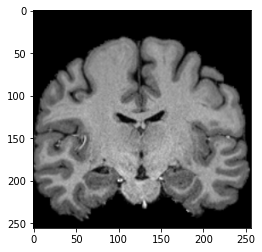

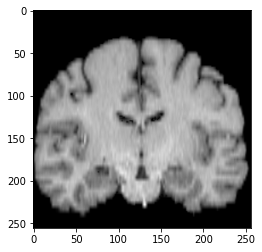

3


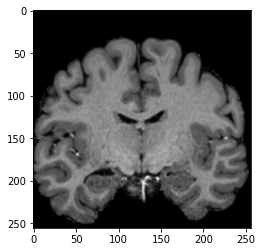

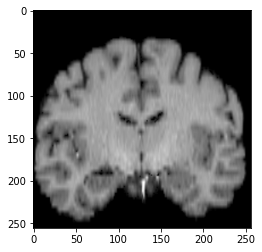

4


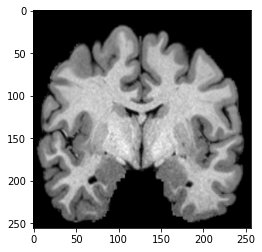

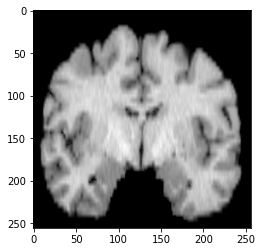

5


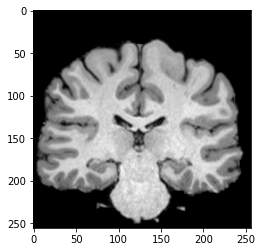

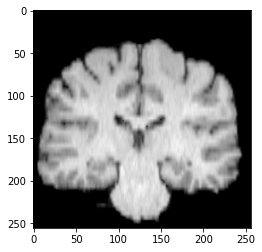

6


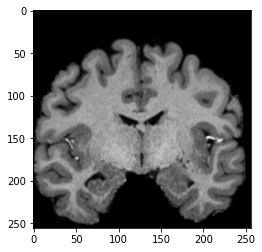

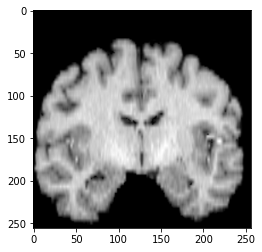

7


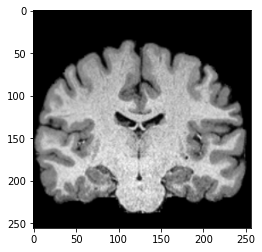

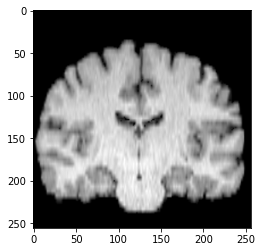

8


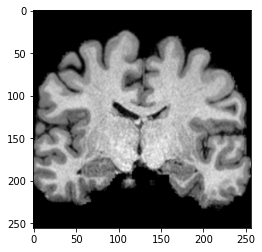

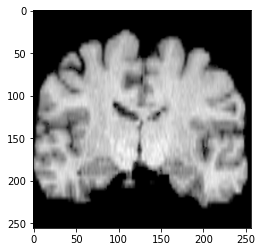

9


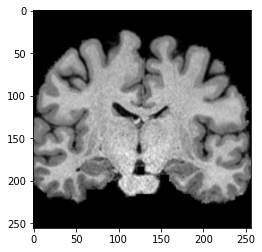

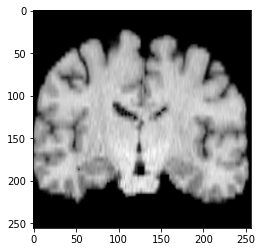

10


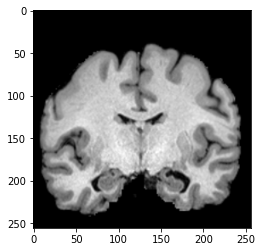

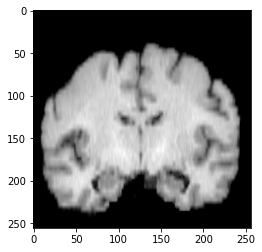

In [9]:
hr_files = glob.glob('./HCP2D/train/*/groundtruth_*.npy')
lr_files = glob.glob('./HCP2D/train/*/lr_*.npy')
batch_size = 2

print(len(hr_files), len(lr_files))
train_dataset = Dataset(hr_files, lr_files)
train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
data = next(iter(train_loader))
len(train_loader)

cnt = 10
for i,data in enumerate(train_loader):
    print(i)
    plt.imshow(data[0][0][0],cmap='gray')
    plt.show()
    plt.imshow(data[1][0][0],cmap='gray')
    plt.show()
    if i == cnt:
        break

146 146
0


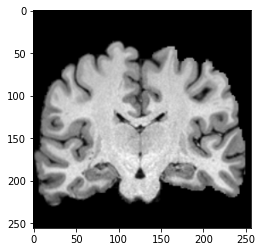

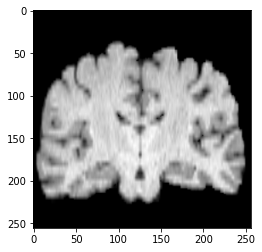

1


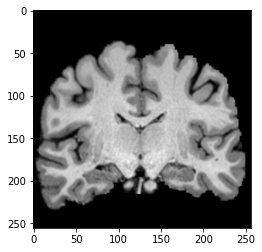

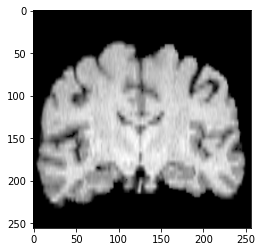

2


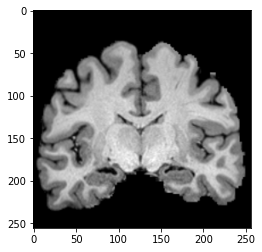

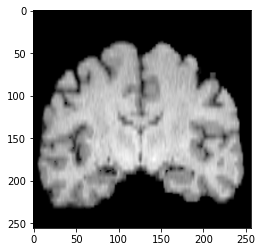

3


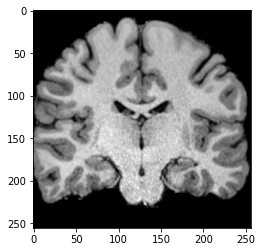

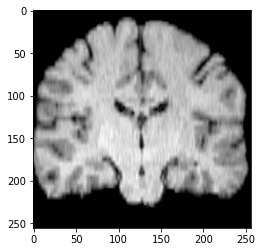

4


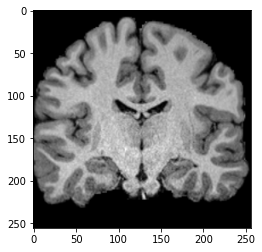

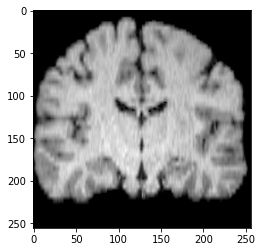

5


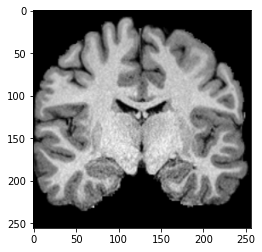

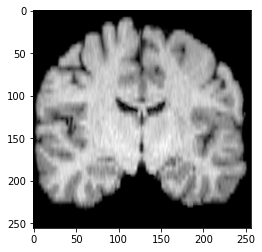

In [10]:
hr_files_test = glob.glob('./HCP2D/test/*/groundtruth_*.npy')
lr_files_test = glob.glob('./HCP2D/test/*/lr_*.npy')
batch_size = 1

print(len(hr_files), len(lr_files))
valid_dataset = Dataset(hr_files_test, lr_files_test)
valid_loader =  DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
data = next(iter(valid_loader))
len(valid_loader)

cnt = 10
for i,data in enumerate(valid_loader):
    print(i)
    plt.imshow(data[0][0][0],cmap='gray')
    plt.show()
    plt.imshow(data[1][0][0],cmap='gray')
    plt.show()
    if i == cnt:
        break

In [12]:
# unet for imagen
unet1 = NullUnet()

unet2 = SRUnet256(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels=1,
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = False,
    cond_on_text =False
)

imagen = Imagen(
    condition_on_text = False, 
    unets = (unet1, unet2),
    image_sizes = (64, 256),
    channels=1,
    timesteps = 1000,
    cond_drop_prob = 0.0
).to(device)

trainer = ImagenTrainer(
    imagen = imagen,
    #cosine_decay_max_steps = len(train_loader)*10,
    split_valid_from_train = False # whether to split the validation dataset from the training
)
trainer.add_train_dataset(train_dataset, batch_size = batch_size)
trainer.add_valid_dataset(valid_dataset, batch_size = 1)

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [ ]:
# working training loop
train_ls = []
valid_ls = []
lst_best = 0
best = 100
for i in range(20000):
    loss = trainer.train_step(unet_number = 2, max_batch_size = 2)
    train_ls.append(loss)
    train_loss_save = pd.DataFrame({'loss': train_ls}).to_csv(os.getcwd()+('/train_loss.csv'), index=False)
    trainer.update(unet_number = 2)
    if not (i % 50):
        print(f'unet: 2, Epoch: {i}, loss: {loss}')
        valid_loss, preds = trainer.valid_step(unet_number = 2, max_batch_size = 2)
        valid_loss = np.mean(valid_loss)
        valid_ls.append(valid_loss)
        valid_loss_save = pd.DataFrame({'loss': valid_ls}).to_csv(os.getcwd()+('/valid_loss.csv'), index=False)
        print(f'valid loss: {valid_loss}')
        if best > valid_loss:
            print("Best model!")
            best = valid_loss
            for j in range(len(preds)):
                preds[j][0][0].save('./results/figures/'+f'conditional_iqt_{j}_pred.png')
            trainer.save('./results/model/checkpoint.pt')
trainer.save('./results/model/last_checkpoint.pt')

unet: 2, Epoch: 0, loss: 0.6680097876193181


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.35519179701805115
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 50, loss: 0.010075590196894864


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.17935548722743988
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 100, loss: 0.005585317768647706


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.08546870201826096
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 150, loss: 0.004807218023390854


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.06259802728891373
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 200, loss: 0.004130479642062461


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.05776814743876457
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 250, loss: 0.0031208120364606485


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.05409551039338112
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 300, loss: 0.0026910145099638414


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.05426149442791939
unet: 2, Epoch: 350, loss: 0.0019175792019256097


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.07582104206085205
unet: 2, Epoch: 400, loss: 0.0016454939511389318


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.055112093687057495
unet: 2, Epoch: 450, loss: 0.0014718952702361555


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.0436532087624073
Best model!
checkpoint saved to ./results/model/checkpoint.pt
unet: 2, Epoch: 500, loss: 0.0014110126351014303


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.06574800610542297
unet: 2, Epoch: 550, loss: 0.001321480653431324


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.05824238061904907
unet: 2, Epoch: 600, loss: 0.0010832151838008966


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

valid loss: 0.05244448408484459


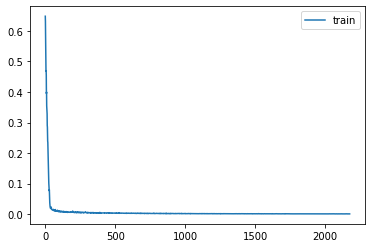

In [10]:
plt.plot(train_ls, label='train')
plt.legend()
plt.show()

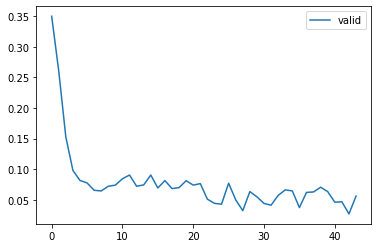

In [11]:
plt.plot(valid_ls, label='valid')
plt.legend()
plt.show()

# Evaluation

In [17]:
trainer.load('./results/model/checkpoint.pt');

checkpoint loaded from ./results/model/checkpoint.pt


In [18]:
images, outputs, lst = trainer.sample(batch_size = 1, return_all_unet_outputs = True, return_pil_images = True, start_image_or_video = test_img.to(device), start_at_unet_number = 2) # returns List[Image]
ls = F.l1_loss(test_img2, outputs[0].cpu())
print("Test loss: ",ls)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Test loss:  tensor(0.0766)


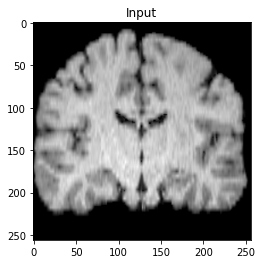

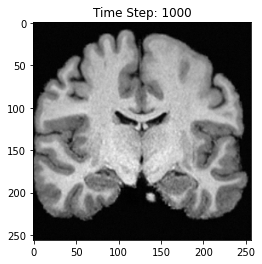

In [19]:
lst2 = []
for i in range(len(lst)):
    if (i % 20 == 0) or (i == len(lst)-1):
        lst2.append(lst[i][0,0].cpu().numpy())
        
plt.imshow(test_img[0,0].cpu().numpy(), cmap='gray')
plt.title("Input".format(i))
plt.show()
plt.imshow(outputs[-1][0,0].cpu().numpy(), cmap='gray')
plt.title("Time Step: {}".format(i))
plt.show()

In [ ]:
# idx = torch.where(test_img2==0)
# img = lst[-1].cpu()+1
# img[idx] = 0
# img.shape

In [ ]:
fig, ax = plt.subplots()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(len(lst2)):
    im = ax.imshow(lst2[i],cmap='gray', animated=True)
    title = ax.text(70, -10, f'Timestep: {i*20}', fontsize=15, bbox={'facecolor': 'blue',
                                       'alpha': 0.5, 'pad': 5})
    if i == 0:
        ax.imshow(lst2[i],cmap='gray')  # show an initial one first
    ims.append([im,title])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=5000)

# To save the animation, use e.g.
#
ani.save("movie.mp4")

plt.show()

In [ ]:
plt.imshow(test_img[0][0],cmap='gray')